In [ ]:
# anime face generation(二次元人物脸部生成)
# 生成对抗网络 GAN
# 数据集 https://drive.google.com/file/d/1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p

In [1]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2022)

# 固定seed 以便可复现性

In [2]:
import os
import glob

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

In [ ]:
# 数据处理
# 1.将图像resize成统一的64*64维度
# 2.将数据从[0,1]线性映射到[-1,1]
# https://pytorch.org/vision/stable/transforms.html 有大量的关于图像的转换方法

In [3]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. 使用read_image读取数据
        img = torchvision.io.read_image(fname)
        # 2. 使用整体的transform进行图像转换
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    # 使用Compose进行封装
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

In [50]:
root_path = 'ML_study/chapter6/'
dataset = get_dataset(root_path + 'faces')

In [7]:
dataset[1].shape
# channel * width * height

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


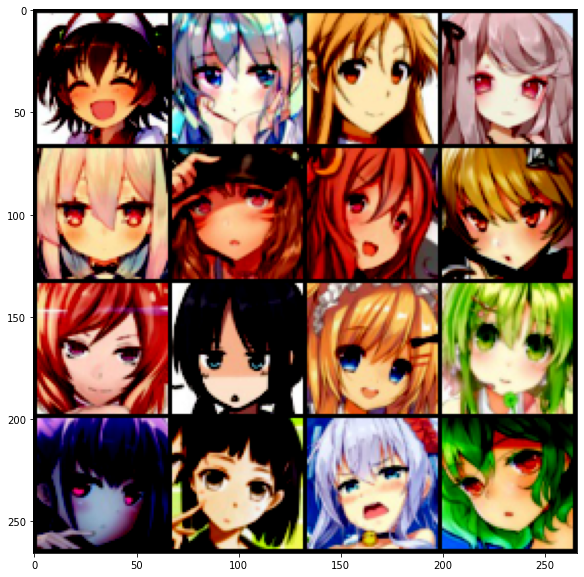

In [6]:
images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4) # nrow是每行放几张图
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
# plt.imshow的维度是[height, width, channel] 所以要转换维度
plt.show()
# 此处显示的是统一到[-1,1]的图像

In [10]:
grid_img.permute(1, 2, 0).shape

torch.Size([266, 266, 3])

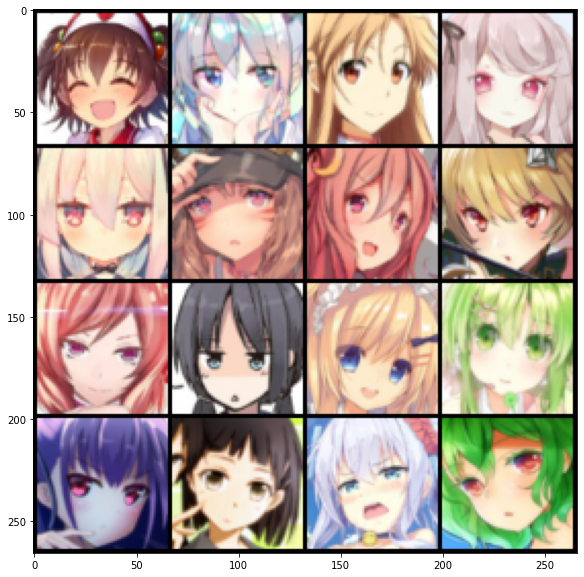

In [11]:
images = [(dataset[i]+1)/2 for i in range(16)]
# 由于把图像统一到[-1,1] 而+1/2可以让图片恢复到[0,1]上 显示出原始图像
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

In [12]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [16]:
class Generator(nn.Module):
    """
    Input shape: (N, in_dim)
    Output shape: (N, 3, 64, 64)
    """
    def __init__(self, in_dim, dim=64):
        super(Generator, self).__init__()
        def dconv_bn_relu(in_dim, out_dim):
            return nn.Sequential(
                nn.ConvTranspose2d(in_dim, out_dim, 5, 2,
                                   padding=2, output_padding=1, bias=False),
                # ConvTranspose2d 可被视为Conv2d对其输入的梯度
                # input [batch, channel_in, height_in, width_in]
                # kernel=5 stride=2 padding=2 output_padding=1 这组参数的结果就是height_out = 2height_in width_out = 2width_in
                # output [batch, channel_out, height_in, width_in]
                nn.BatchNorm2d(out_dim),
                nn.ReLU()
            )
        self.l1 = nn.Sequential(
            nn.Linear(in_dim, dim * 8 * 4 * 4, bias=False),
            nn.BatchNorm1d(dim * 8 * 4 * 4),
            nn.ReLU()
        )
        self.l2_5 = nn.Sequential(
            dconv_bn_relu(dim * 8, dim * 4), # 4->8
            dconv_bn_relu(dim * 4, dim * 2), # 8->16
            dconv_bn_relu(dim * 2, dim), # 16->32
            nn.ConvTranspose2d(dim, 3, 5, 2, padding=2, output_padding=1), # 32->64
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.l1(x) # [batch, in_dim] -> [batch, dim * 8 * 4 * 4]
        y = y.view(y.size(0), -1, 4, 4) # [batch, dim * 8 * 4 * 4] -> [batch, dim * 8, 4, 4]
        y = self.l2_5(y) # [batch, dim * 8, 4, 4] -> [batch, 3, 64, 64] # 每个batch就是一张图片
        return y

In [46]:
class Discriminator(nn.Module):
    """
    Input shape: (N, 3, 64, 64)
    Output shape: (N, )
    """
    def __init__(self, in_dim, dim=64):
        super(Discriminator, self).__init__()

        def conv_bn_lrelu(in_dim, out_dim):
            return nn.Sequential(
                nn.Conv2d(in_dim, out_dim, 5, 2, 2),
                nn.BatchNorm2d(out_dim),
                nn.LeakyReLU(0.2),
            )

        """ Medium: Remove the last sigmoid layer for WGAN. """
        self.ls = nn.Sequential(
            nn.Conv2d(in_dim, dim, 5, 2, 2), # [batch, 3, 64, 64] -> [batch, dim, 32, 32]
            nn.LeakyReLU(0.2),
            conv_bn_lrelu(dim, dim * 2), # [batch, dim*2, 16, 16]
            conv_bn_lrelu(dim * 2, dim * 4), # [batch, dim*4, 8, 8]
            conv_bn_lrelu(dim * 4, dim * 8), # [batch, dim*8, 4, 4]
            nn.Conv2d(dim * 8, 1, 4), # [batch, 1, 1, 1]
            nn.Sigmoid(),
        )
        self.apply(weights_init)

    def forward(self, x):
        y = self.ls(x) # [batch, 3, 64, 64] -> [batch, 1, 4, 4]
        y = y.view(-1) # [batch]
        return y

In [47]:
test_data = torch.randn(16, 32)
generator = Generator(in_dim=32)
discriminator = Discriminator(in_dim=3)

In [48]:
generator_output = generator(test_data)
generator_output.shape

torch.Size([16, 3, 64, 64])

In [49]:
discriminator_output = discriminator(generator_output)
discriminator_output.shape

torch.Size([16])

In [52]:
# Training hyperparameters
batch_size = 64
z_dim = 100
z_sample = Variable(torch.randn(100, z_dim)).cuda(2)
lr = 1e-4

""" Medium: WGAN, 50 epoch, n_critic=5, clip_value=0.01 """
n_epoch = 1 # 50
n_critic = 1 # 5
# clip_value = 0.01

log_dir = os.path.join(root_path, 'results/logs')
ckpt_dir = os.path.join(root_path, 'results/checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Model
G = Generator(in_dim=z_dim).cuda(2)
D = Discriminator(3).cuda(2)
G.train()
D.train()

# Loss
criterion = nn.BCELoss()

""" Medium: Use RMSprop for WGAN. """
# Optimizer
opt_D = torch.optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
# opt_D = torch.optim.RMSprop(D.parameters(), lr=lr)
# opt_G = torch.optim.RMSprop(G.parameters(), lr=lr)


# DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

None

IpythonBar(children=(HTML(value='  0.0%'), FloatProgress(value=0.0)))

 | Save some samples to ML_study/chapter6/results/logs/Epoch_001.jpg.


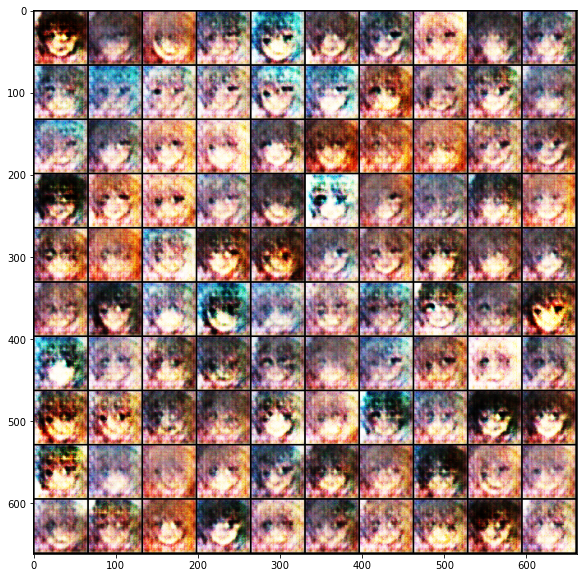

In [54]:
steps = 0
for e, epoch in enumerate(range(n_epoch)):
    progress_bar = qqdm(dataloader)
    for i, data in enumerate(progress_bar):
        imgs = data
        imgs = imgs.cuda(2)

        bs = imgs.size(0)

        # ============================================
        #  Train D
        # ============================================
        z = Variable(torch.randn(bs, z_dim)).cuda(2)
        # 按照正态分布 取batch_size * z_dim 维度的分布采样
        r_imgs = Variable(imgs).cuda(2) # real img
        f_imgs = G(z) # fake img

        """ Medium: Use WGAN Loss. """
        # Label
        r_label = torch.ones((bs)).cuda(2) # real img 的label是1
        f_label = torch.zeros((bs)).cuda(2) # fake img的 label是0

        # Model forwarding
        r_logit = D(r_imgs.detach())
        f_logit = D(f_imgs.detach())
        # 算出分类结果 0-1的打分值

        # Compute the loss for the discriminator.
        r_loss = criterion(r_logit, r_label)
        # real loss 就是真实的和1之间的差距
        f_loss = criterion(f_logit, f_label)
        # fake loss 就是假的和0之间的差距
        loss_D = (r_loss + f_loss) / 2

        # WGAN Loss
        # loss_D = -torch.mean(D(r_imgs)) + torch.mean(D(f_imgs))


        # Model backwarding
        D.zero_grad()
        loss_D.backward()

        # Update the discriminator.
        opt_D.step()

        """ Medium: Clip weights of discriminator. """
        # for p in D.parameters():
        #    p.data.clamp_(-clip_value, clip_value)

        # ============================================
        #  Train G
        # ============================================
        if steps % n_critic == 0:
            # Generate some fake images.
            z = Variable(torch.randn(bs, z_dim)).cuda(2)
            f_imgs = G(z)
            # Generator产生虚假图像

            # Model forwarding
            f_logit = D(f_imgs)
            # 辨别器进行辨别

            """ Medium: Use WGAN Loss"""
            # Compute the loss for the generator.
            loss_G = criterion(f_logit, r_label)
            # 因为此时要以假乱真 所以loss是虚假图片和真实标签1之间的差距
            # WGAN Loss
            # loss_G = -torch.mean(D(f_imgs))

            # Model backwarding
            G.zero_grad()
            loss_G.backward()

            # Update the generator.
            opt_G.step()

        steps += 1

        # Set the info of the progress bar
        #   Note that the value of the GAN loss is not directly related to
        #   the quality of the generated images.
        progress_bar.set_infos({
            'Loss_D': round(loss_D.item(), 4),
            'Loss_G': round(loss_G.item(), 4),
            'Epoch': e+1,
            'Step': steps,
        })

    G.eval()
    f_imgs_sample = (G(z_sample).data + 1) / 2.0
    filename = os.path.join(log_dir, f'Epoch_{epoch+1:03d}.jpg')
    torchvision.utils.save_image(f_imgs_sample, filename, nrow=10)
    print(f' | Save some samples to {filename}.')

    # Show generated images in the jupyter notebook.
    grid_img = torchvision.utils.make_grid(f_imgs_sample.cpu(), nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.show()
    G.train()

    if (e+1) % 5 == 0 or e == 0:
        # Save the checkpoints.
        torch.save(G.state_dict(), os.path.join(ckpt_dir, 'G.pth'))
        torch.save(D.state_dict(), os.path.join(ckpt_dir, 'D.pth'))


In [56]:
import torch

G = Generator(z_dim)
G.load_state_dict(torch.load(os.path.join(ckpt_dir, 'G.pth')))
G.eval()
G.cuda(2)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=False)
    (1): BatchNorm1d(8192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (l2_5): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()


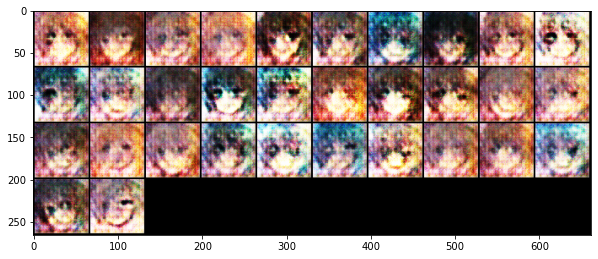

In [58]:
# Generate 1000 images and make a grid to save them.
n_output = 1000
z_sample = Variable(torch.randn(n_output, z_dim)).cuda(2)
imgs_sample = (G(z_sample).data + 1) / 2.0
log_dir = os.path.join(root_path, 'results/logs')
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(imgs_sample, filename, nrow=10)

# Show 32 of the images.
grid_img = torchvision.utils.make_grid(imgs_sample[:32].cpu(), nrow=10)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()
